## Neural Networks and Deep Learning CIFAR-10 dataset
The notebook shows how to build a customized convolutional neural network for CIFAR-10 image recognition

In [1]:
# Importing relevant libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np


### Data Preparation and Augmentation

In [2]:
# Transformations of sets, cutout added as well,normalized according to the best practice related to this dataset.
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.247, 0.243, 0.261)),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.25), ratio=(0.3, 3.3), value=0)
])


transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.247, 0.243, 0.261))
])



### Downloading CIFAR-10 and placing into relevant directory.


In [3]:

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
trainloader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
testloader = DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

# Class labels acc to dataset
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

100%|██████████| 170M/170M [00:03<00:00, 46.5MB/s]


### General Architecture

### Custom Intermediate Block: Dynamic Convolutional Layer

In [4]:
class DynamicConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, branches=3, dropout_p=0.0):
        super().__init__()
        self.branches = branches

        # Small network that predicts soft weights for each branch
        self.weight_net = nn.Sequential(
            nn.Conv2d(in_ch, in_ch, kernel_size=1),  # reduce spatial info
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1),  # global pooling to get feature summary
            nn.Flatten(),
            nn.Linear(in_ch, branches),  # predicts score for each branch
        )

        # Define parallel convolution paths (independent convs)
        self.paths = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True)
            )
            for _ in range(branches)
        ])

        # If in/out channels mismatch, use a shortcut conv to align
        self.shortcut = (
            nn.Identity() if in_ch == out_ch else nn.Conv2d(in_ch, out_ch, kernel_size=1)
        )

        self.drop = nn.Dropout2d(dropout_p)  # spatial dropout to regularize

    def forward(self, x):
        # Compute weights for each branch (shape: [B, branches, 1, 1, 1])
        weights = self.weight_net(x)
        weights = F.softmax(weights, dim=1).unsqueeze(2).unsqueeze(3).unsqueeze(4)

        # Run input through each conv branch, stack along new dimension
        out = [branch(x).unsqueeze(1) for branch in self.paths]
        out = torch.cat(out, dim=1)

        # Fuse branch outputs using soft weights
        fused = (weights * out).sum(dim=1)

        # Apply dropout, then add shortcut connection
        fused = self.drop(fused)
        return fused + self.shortcut(x)


### Output block for final classification

In [5]:
class OutputBlock(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(OutputBlock, self).__init__()
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(in_channels, num_classes)

    def forward(self, x):
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)


### Assembling the CIFAR-10 Classification Model

In [6]:
class SmartCIFAR10Net(nn.Module):
    def __init__(self):
        super(SmartCIFAR10Net, self).__init__()
        self.block1 = DynamicConvBlock(3, 64, branches=3)
        self.block2 = DynamicConvBlock(64, 128, branches=3)
        self.block3 = DynamicConvBlock(128, 256, branches=3)
        self.block4 = DynamicConvBlock(256, 512, branches=3)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.3)
        self.output = OutputBlock(512, 10)

    def forward(self, x):
        x = self.block1(x)
        x = self.pool(x)

        x = self.block2(x)
        x = self.pool(x)

        x = self.block3(x)
        x = self.pool(x)

        x = self.block4(x)
        x = self.dropout(x)

        x = self.output(x)
        return x


### Model Compilation: device,loss,optimizer,scheduler

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SmartCIFAR10Net().to(device)

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Scheduler – reduces LR halfway through
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)


### Model Training and Evaluation

In [11]:
trainloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=0)
testloader = DataLoader(testset, batch_size=64, shuffle=False, num_workers=0)

num_epochs = 50
loss_curve = []
acc_train_hist = []
acc_test_hist = []
lr_timeline = []

for epoch_num in range(1, num_epochs + 1):
    model.train()

    epoch_loss = []
    num_correct = 0
    total_seen = 0

    for batch_imgs, batch_labels in trainloader:
        batch_imgs, batch_labels = batch_imgs.to(device), batch_labels.to(device)

        optimizer.zero_grad()
        preds = model(batch_imgs)
        loss = criterion(preds, batch_labels)
        loss.backward()
        optimizer.step()

        epoch_loss.append(loss.item())

        _, preds_class = preds.max(1)
        num_correct += (preds_class == batch_labels).sum().item()
        total_seen += batch_labels.size(0)

    # Save loss and accuracy for this epoch
    avg_loss = sum(epoch_loss) / len(epoch_loss)
    train_acc = 100.0 * num_correct / total_seen
    loss_curve.extend(epoch_loss)
    acc_train_hist.append(train_acc)

    # Evaluation mode
    model.eval()
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for val_imgs, val_labels in testloader:
            val_imgs, val_labels = val_imgs.to(device), val_labels.to(device)
            out = model(val_imgs)
            _, predicted_class = out.max(1)
            test_correct += (predicted_class == val_labels).sum().item()
            test_total += val_labels.size(0)
    test_acc = 100.0 * test_correct / test_total
    acc_test_hist.append(test_acc)

    # Track learning rate
    curr_lr = optimizer.param_groups[0]['lr']
    lr_timeline.append(curr_lr)
    scheduler.step()

    print(f"[{epoch_num:02d}/{num_epochs}] loss={avg_loss:.3f} | train={train_acc:.2f}% | test={test_acc:.2f}% | lr={curr_lr:.5f}")


[01/50] loss=1.062 | train=62.05% | test=63.61% | lr=0.00100
[02/50] loss=0.915 | train=67.46% | test=70.73% | lr=0.00100
[03/50] loss=0.823 | train=71.00% | test=70.70% | lr=0.00100
[04/50] loss=0.763 | train=73.03% | test=75.97% | lr=0.00100
[05/50] loss=0.709 | train=75.28% | test=74.48% | lr=0.00100
[06/50] loss=0.676 | train=76.18% | test=76.87% | lr=0.00100
[07/50] loss=0.635 | train=77.81% | test=78.38% | lr=0.00100
[08/50] loss=0.611 | train=78.62% | test=79.68% | lr=0.00100
[09/50] loss=0.584 | train=79.62% | test=80.02% | lr=0.00100
[10/50] loss=0.561 | train=80.34% | test=79.96% | lr=0.00100
[11/50] loss=0.544 | train=80.93% | test=80.73% | lr=0.00100
[12/50] loss=0.530 | train=81.40% | test=81.82% | lr=0.00100
[13/50] loss=0.511 | train=82.11% | test=81.02% | lr=0.00100
[14/50] loss=0.491 | train=82.77% | test=81.76% | lr=0.00100
[15/50] loss=0.477 | train=83.29% | test=82.52% | lr=0.00100
[16/50] loss=0.460 | train=83.79% | test=82.65% | lr=0.00100
[17/50] loss=0.456 | tra

### Visualizing Training Results

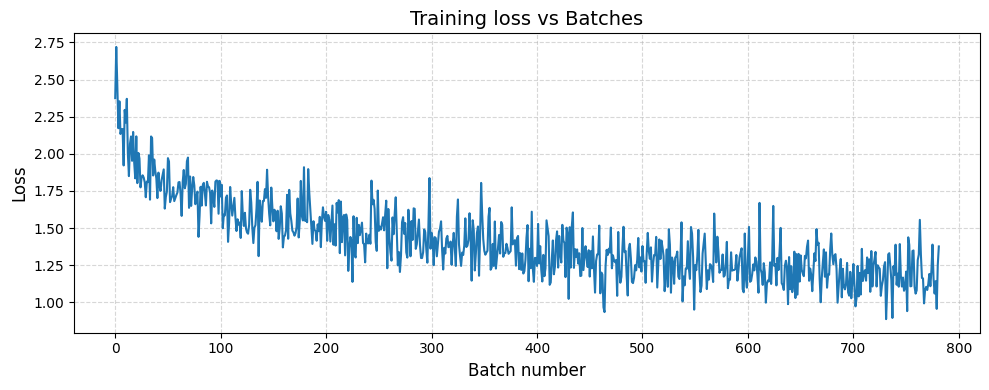

In [9]:
plt.figure(figsize=(10, 4))
plt.plot(loss_curve, color='#1f77b4', linewidth=1.5)  # soft blue
plt.title("Training loss vs Batches", fontsize=14)
plt.xlabel("Batch number", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


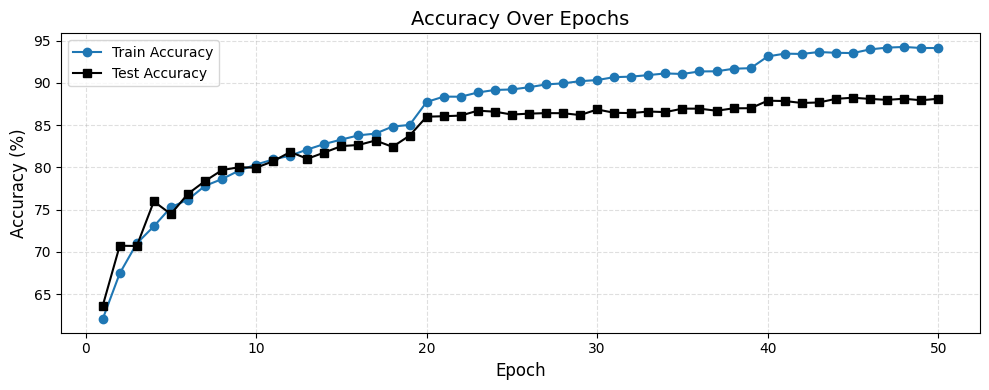

In [12]:
epochs = list(range(1, len(acc_train_hist) + 1))

plt.figure(figsize=(10, 4))
plt.plot(epochs, acc_train_hist, marker='o', label="Train Accuracy", color='#1f77b4')
plt.plot(epochs, acc_test_hist, marker='s', label="Test Accuracy", color='#000000')
plt.title("Accuracy Over Epochs", fontsize=14)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Accuracy (%)", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()